In [18]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

import os
import pandas as pd
import numpy as np
import cx_Oracle
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix,accuracy_score, classification_report, plot_roc_curve, plot_precision_recall_curve,roc_auc_score
from joblib import dump, load

os.chdir('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado')
import pipeline_bm as pipeline
#pd.set_option('display.max_row', 1000000)

pipeline_bm = pipeline.clase_pipeline()

In [19]:
# Open the file in binary mode, remove null bytes, and then decode
with open('G:\\Mi unidad\\SOCOFAR\\0.-Recomendadores-Oficial\\Archivos\\SR_BASE_FINAL_PROD_FEB24.csv', 'rb') as file:
    content = file.read().replace(b'\x00', b'')  # Replace null bytes with nothing

# Convert the binary content to a string and use StringIO to mimic a file object for pandas
from io import StringIO
content_str = StringIO(content.decode('latin'))

# Now use pd.read_csv on the cleaned string data
df = pd.read_csv(content_str, sep=';', encoding='latin',nrows=10000000)
df['RUT_CLIENTE']=((df['SK']+1599)/2).astype(int)

In [20]:
#AQUI SE PUEDE REALIZAR UN MUESTREO 50/50 DE TARGETS 1 Y 0

In [21]:
# Agrupar los productos comprados por cada 'rut' en una lista
sentences = df.groupby('RUT_CLIENTE')['CODIGO_PRODUCTO'].apply(list).tolist()

# Entrenar el modelo Word2Vec con las 'oraciones' de productos
model = Word2Vec(sentences, vector_size=10, window=5, min_count=1, workers=4)

In [22]:
client_embeddings = {}
for rut, group in df.groupby('RUT_CLIENTE'):
    products = group['CODIGO_PRODUCTO'].tolist()
    embeddings = []
    for product in products:
        embeddings.append(model.wv[product])
        
    if embeddings:
        client_embeddings[rut] = np.mean(embeddings, axis=0)

In [23]:
client_embeddings_df = pd.DataFrame.from_dict(client_embeddings, orient='index')
client_embeddings_df.reset_index(inplace=True)
client_embeddings_df.columns = ['RUT_CLIENTE'] + [f'embedding_{i}' for i in range(model.vector_size)]        

In [24]:
# diccionario=pd.read_csv('../diccionario_productos.csv',sep=';',usecols=['CODIGO','UNIDAD_COMERCIAL','MACROCATEGORIA','CATEGORIA_NIVEL_1','CATEGORIA_NIVEL_2_FCV','DESCRIPTOR_LARGO','MARCA'])

# excl_otros = [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.isin(['DESPACHO','DESP.A','RETIRO DE RECETA','PROMOCION DTE','HORA VACUNACION','INSUMOS BOLSAS','SIN DESCRIPTOR','AJUSTE POR REDONDEO'])]['CODIGO'])] +\
#                           [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.str.contains('BOLSA PAPEL|BOLS|DESPACHO|PROMOCION|CUPON|INYECCION|MEDICION|MEMBRESIA|REGALO|2020|2021|2022|MUNDIAL')]['CODIGO'])] +\
#                           [str(elemento) for elemento in list(diccionario[diccionario.MACROCATEGORIA.isin(['ENFERMERIA ACCESORIOS Y PROCEDIMIENTOS','HOGAR','RECARGAS VARIAS','BEBIDAS Y AGUAS','ACCESORIOS MODA','TECNOLOGIA','AUTOLIQUIDABLES REGALO ARTICULOS VARIOS','INSUMOS MACRO','EQUIPOS QUIRURGICOS','POR CLASIFICAR'])]['CODIGO'])] +\
#                           [str(elemento) for elemento in list(diccionario[diccionario.CATEGORIA_NIVEL_1.isin(['MASCARILLAS PRIMEROS AUXILIOS'])]['CODIGO'])] +\
#                           [str(elemento) for elemento in list(diccionario[diccionario.UNIDAD_COMERCIAL.isin(['INSTITUCIONAL'])]['CODIGO'])]
# #por código
# cods_excluir = pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/Archivos/codigos_exclusion.csv',sep=';').excluir.values.tolist() + excl_otros
# cods_excluir = [int(cod) for cod in cods_excluir]

# dicc_productos=diccionario[~diccionario.CODIGO.isin(cods_excluir)].CODIGO

In [25]:
dicc_productos=df['CODIGO_PRODUCTO'].unique()
#min=dicc_productos.quantile(0.2)
#dicc_productos = dicc_productos[dicc_productos > min]
#len(dicc_productos)
df['CODIGO_PRODUCTO'].value_counts()

293450    169053
72203      80760
260536     75848
72202      74670
273362     65622
           ...  
270966         1
274636         1
182104         1
205184         1
282592         1
Name: CODIGO_PRODUCTO, Length: 13302, dtype: int64

In [26]:
len(dicc_productos)

13302

In [27]:
dataframes_por_producto = {}  # Para almacenar el DataFrame de cada producto
for producto in dicc_productos:
    if producto==293450:
        print(producto)
        # Crear una copia de client_embeddings_df para no modificar el original
        df_temporal = client_embeddings_df.copy()
        
        # Identificar los clientes que han comprado el producto actual
        clientes_con_producto = df[df['CODIGO_PRODUCTO'] == producto]['RUT_CLIENTE'].unique()
        
        # Crear la columna 'target' basada en la condición de si el RUT_CLIENTE compró el producto
        df_temporal['target'] = df_temporal['RUT_CLIENTE'].apply(lambda x: 1 if x in clientes_con_producto else 0)
        
        # Almacenar el DataFrame resultante en el diccionario con la clave siendo el código del producto
        dataframes_por_producto[producto] = df_temporal

293450


In [28]:
excluir = ['RUT_CLIENTE', 'target']
columnas_para_redondear = [col for col in df_temporal.columns if col not in excluir and (df_temporal[col].dtype == 'float64' or df_temporal[col].dtype == 'float32')]
df_temporal[columnas_para_redondear] = df_temporal[columnas_para_redondear].round(8)
df_temporal.head()     

,RUT_CLIENTE,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,target
0,1000232,-0.6208,-0.2480,2.0852,-1.0675,-0.2276,-0.7499,-0.2187,0.2429,-0.4754,...,-0.0740,0.1152,-0.8653,0.0271,1.2854,-1.1002,-1.2246,-0.1336,-0.5087,0
1,1000425,-0.1304,0.1049,0.2105,-0.6745,-1.1291,-0.8342,-0.8321,-0.7262,-0.4445,...,-0.4990,0.6467,-0.0502,0.1381,0.8189,-0.7818,-1.2185,-0.0160,0.4573,0
2,1000795,-0.4174,-0.0704,0.0612,0.1394,-0.7188,0.0617,0.8816,0.6903,-0.6173,...,-0.6691,0.2967,0.0355,0.0875,-0.3287,-0.2355,-0.4880,-1.1266,-0.1995,0
3,1001229,0.6467,0.2568,0.4830,-0.6142,-0.3558,0.0283,0.0027,0.1321,-0.5512,...,-0.0548,0.2568,-0.0398,-0.0717,1.1400,0.0389,-0.3963,-0.3471,-1.1470,1
4,1001378,-0.2909,0.1348,-0.0179,0.0538,-0.3222,0.3355,0.3861,0.4282,-0.8240,...,-0.5847,0.1933,-0.0501,0.3439,0.0973,0.1476,-0.2978,-0.8544,-0.2366,0


#### **MODELADO**

In [29]:
#df_temporal.to_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado/data1.csv',sep=';',index=False)
#pipeline_bm.dataset = pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado/data1.csv',delimiter=';')

In [30]:
pipeline_bm.dataset=df_temporal

In [31]:
pipeline_bm.recibe_data(
    tipo = 'dataframe',
    dataset_o_query = '',
    target = 'TARGET',
    delimiter=';' ,
    #muestra = 'MUESTRA',
    #ano_mes = 'FECHA_VENTA',
    rut = 'RUT_CLIENTE', 
    excluir=[],
    categoricas=[]
)

Procesando...
cargar previamente pipeline_bm.dataset = nombre_dataframe
________________________________________________________________________________________________________________________
Datos recibidos: OK.
Número de filas y columnas del dataset: (4178864, 22)
________________________________________________________________________________________________________________________


In [32]:
pipeline_bm.dataset.head()

,RUT_CLIENTE,EMBEDDING_0,EMBEDDING_1,EMBEDDING_2,EMBEDDING_3,EMBEDDING_4,EMBEDDING_5,EMBEDDING_6,EMBEDDING_7,EMBEDDING_8,...,EMBEDDING_11,EMBEDDING_12,EMBEDDING_13,EMBEDDING_14,EMBEDDING_15,EMBEDDING_16,EMBEDDING_17,EMBEDDING_18,EMBEDDING_19,TARGET
0,1000232,-0.6208,-0.2480,2.0852,-1.0675,-0.2276,-0.7499,-0.2187,0.2429,-0.4754,...,-0.0740,0.1152,-0.8653,0.0271,1.2854,-1.1002,-1.2246,-0.1336,-0.5087,0
1,1000425,-0.1304,0.1049,0.2105,-0.6745,-1.1291,-0.8342,-0.8321,-0.7262,-0.4445,...,-0.4990,0.6467,-0.0502,0.1381,0.8189,-0.7818,-1.2185,-0.0160,0.4573,0
2,1000795,-0.4174,-0.0704,0.0612,0.1394,-0.7188,0.0617,0.8816,0.6903,-0.6173,...,-0.6691,0.2967,0.0355,0.0875,-0.3287,-0.2355,-0.4880,-1.1266,-0.1995,0
3,1001229,0.6467,0.2568,0.4830,-0.6142,-0.3558,0.0283,0.0027,0.1321,-0.5512,...,-0.0548,0.2568,-0.0398,-0.0717,1.1400,0.0389,-0.3963,-0.3471,-1.1470,1
4,1001378,-0.2909,0.1348,-0.0179,0.0538,-0.3222,0.3355,0.3861,0.4282,-0.8240,...,-0.5847,0.1933,-0.0501,0.3439,0.0973,0.1476,-0.2978,-0.8544,-0.2366,0


In [33]:
len(pipeline_bm.dataset)

4178864

In [34]:
pipeline_bm.separa_muestras(test=0.3)

Separacion de muestras: OK.
________________________________________________________________________________________________________________________


In [35]:
pipeline_bm.modelacion('RandomForest', perf_eval='f1',ruta_exporta='G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado/modelo_rf.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.638 total time= 3.2min
[CV 2/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.639 total time= 2.7min
[CV 3/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.642 total time= 2.7min
best params: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 50, 'n_jobs': -1, 'oob_score': True, 'random_state': 0}
best estimator: RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=0)
ROC: 0.9693074099492301
Modelación: OK.
________________________________________________________________________________________________________________________

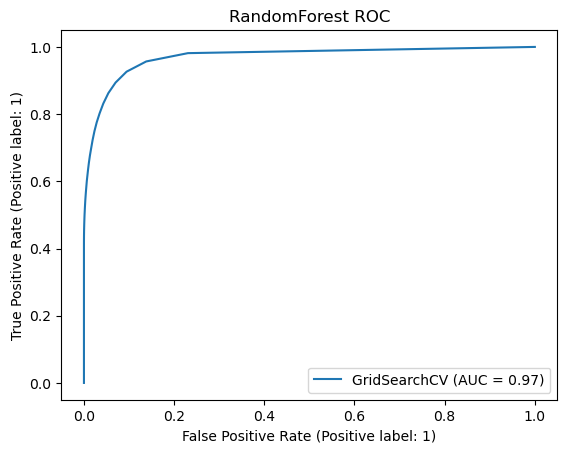

In [36]:
%matplotlib inline
plot_roc_curve(pipeline_bm.model, pipeline_bm.X_test, pipeline_bm.Y_test)
plt.title(pipeline_bm.algoritmo + ' ROC')
plt.show()

In [37]:
pipeline_bm.metricas_modelo_optimo()
pipeline_bm.confusion_matrix

"ROC OPTIMO"

sens+espc:  1.8318128552710824
KS:  0.8318128552710824
threshold optimo:  0.059000000000000004
sensibility:  0.9263967882234861
specificity:  0.9054160670475963
precision:  0.2926642751005639
negative predictive value:  0.9965776520680041
Critical Success Index:  0.2860137438253039
accuracy:  0.9062664518290445
f1score:  0.4448066674226103
BalancedAccuracy:  0.9159064276355412


TARGET,0,1
pred,,
0,1089077,3740
1,113770,47073


Lo esperable es que el modelo ajuste extremadamente bien ya que se le proporcionan implicitamente lo productos que compró a través del embbeding del cliente. 
Lo importante acá es que, de cara al uso, la probabilidad hacia un producto no comprado por el cliente será más alta en la medida en que el embbeding del cliente contenga el resto de productos que normalmente los clientes compran junto con el.

no se interprete el acierto de este modelo con la efectividad de las recomendaciones en terminos de "acabar en compra"

In [43]:
x = 1.4116  # Este es tu nuevo valor para la variable "embedding_0"

# Los datos deben ser un array bidimensional, como se espera en sklearn
# El nuevo valor "x" se coloca en una lista de una sola lista para cumplir con esto
x_array = np.array([[x]])
x_array
# Realizar la predicción

for i in range(0,10):
    prob=pipeline_bm.model.predict_proba(x_array)[:,1]
    print(str(i)+': '+str(prob))


array([0.93752233])